## Model Optimization for Diverse Classification Tasks

#### 1. Dataset Cleaning & Processing for BrinjalFruitX

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import json

# --- 1. Configuration ---
# Define paths and parameters
RAW_DATA_DIR = os.path.join('raw_data', 'BrinjalFruitX')
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
IMG_SIZE = (224, 224)
TEST_SPLIT_SIZE = 0.20 # 20% for the final test set
VALIDATION_SPLIT_SIZE = 0.125 # 10% of the original data (0.125 * 0.8 = 0.1)
RANDOM_STATE = 42 # For reproducible splits

# --- 2. Create Processed Data Directory ---
# This ensures the folder exists before we try to save files to it.
os.makedirs(PROCESSED_DIR, exist_ok=True)
print(f"Directory '{PROCESSED_DIR}' is ready.")

# --- 3. Load Images and Labels ---
images = []
labels = []

# Get class names from the folder names in the raw data directory
class_names = sorted([d for d in os.listdir(RAW_DATA_DIR) if os.path.isdir(os.path.join(RAW_DATA_DIR, d))])
# Create a mapping from class name to an integer index
label_map = {name: i for i, name in enumerate(class_names)}

print("Starting image loading and preprocessing...")
# Use tqdm for a progress bar
for class_name in tqdm(class_names, desc="Processing classes"):
    class_path = os.path.join(RAW_DATA_DIR, class_name)
    class_label = label_map[class_name]

    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)

        # Read the image
        image = cv2.imread(image_path)

        # Check if the image was loaded correctly
        if image is not None:
            # Convert image from BGR (OpenCV's default) to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Resize image to the standard size
            image = cv2.resize(image, IMG_SIZE)
            
            images.append(image)
            labels.append(class_label)
        else:
            print(f"Warning: Could not read image {image_path}. Skipping.")

print("Image loading complete.")

# --- 4. Convert to NumPy Arrays and Normalize ---
# Convert lists to NumPy arrays for efficient processing
images_np = np.array(images)
labels_np = np.array(labels)

# Normalize pixel values from the [0, 255] range to the [0.0, 1.0] range
images_np = images_np / 255.0

print(f"Converted to NumPy arrays. Image data shape: {images_np.shape}, Labels shape: {labels_np.shape}")

# --- 5. Split the Data ---
# First split: separate out the 20% test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images_np,
    labels_np,
    test_size=TEST_SPLIT_SIZE,
    random_state=RANDOM_STATE,
    stratify=labels_np  # Ensures class distribution is similar across splits
)

# Second split: separate the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=VALIDATION_SPLIT_SIZE, # 0.125 of the 80% results in 10% of the original data
    random_state=RANDOM_STATE,
    stratify=y_train_val # Stratify again for the validation split
)

print("Data splitting complete:")
print(f"  Training set:   {X_train.shape[0]} samples")
print(f"  Validation set: {X_val.shape[0]} samples")
print(f"  Test set:       {X_test.shape[0]} samples")

# --- 6. Save the Processed Data ---
print("Saving processed data to .npy files...")

np.save(os.path.join(PROCESSED_DIR, 'X_train.npy'), X_train)
np.save(os.path.join(PROCESSED_DIR, 'y_train.npy'), y_train)

np.save(os.path.join(PROCESSED_DIR, 'X_val.npy'), X_val)
np.save(os.path.join(PROCESSED_DIR, 'y_val.npy'), y_val)

np.save(os.path.join(PROCESSED_DIR, 'X_test.npy'), X_test)
np.save(os.path.join(PROCESSED_DIR, 'y_test.npy'), y_test)

# Save the class names/label map for later use in decoding predictions
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'w') as f:
    json.dump(class_names, f)

print("All data has been processed and saved successfully! ✅")

Directory 'processed_data' is ready.
Starting image loading and preprocessing...


Processing classes: 100%|██████████| 5/5 [00:55<00:00, 11.11s/it]


Image loading complete.
Converted to NumPy arrays. Image data shape: (1802, 224, 224, 3), Labels shape: (1802,)
Data splitting complete:
  Training set:   1260 samples
  Validation set: 181 samples
  Test set:       361 samples
Saving processed data to .npy files...
All data has been processed and saved successfully! ✅


#### 2. ResNet Model

c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Loading preprocessed data...
Data loaded successfully.
  Training data shape: (1260, 224, 224, 3)
  Number of classes: 5
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


Starting model training...
Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 560ms/step - accuracy: 0.2401 - loss: 1.9102 - val_accuracy: 0.4254 - val_loss: 1.4160
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 508ms/step - accuracy: 0.3329 - loss: 1.5947 - val_accuracy: 0.4530 - val_loss: 1.4031
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 509ms/step - accuracy: 0.4001 - loss: 1.5003 - val_accuracy: 0.2873 - val_loss: 1.4391
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 509ms/step - accuracy: 0.3853 - loss: 1.4816 - val_accuracy: 0.4365 - val_loss: 1.4005
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 511ms/step - accuracy: 0.4240 - loss: 1.4345 - val_accuracy: 0.4972 - val_loss: 1.3760
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 509ms/step - accuracy: 0.4160 - loss: 1.4368 - val_accuracy: 0.4696 - val_loss: 1.3757
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 506ms/step - accuracy: 0.4581 - loss: 1.3605 - val_accuracy: 0.4972 - val_loss: 1.3712
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 510ms/step - accuracy: 0.47

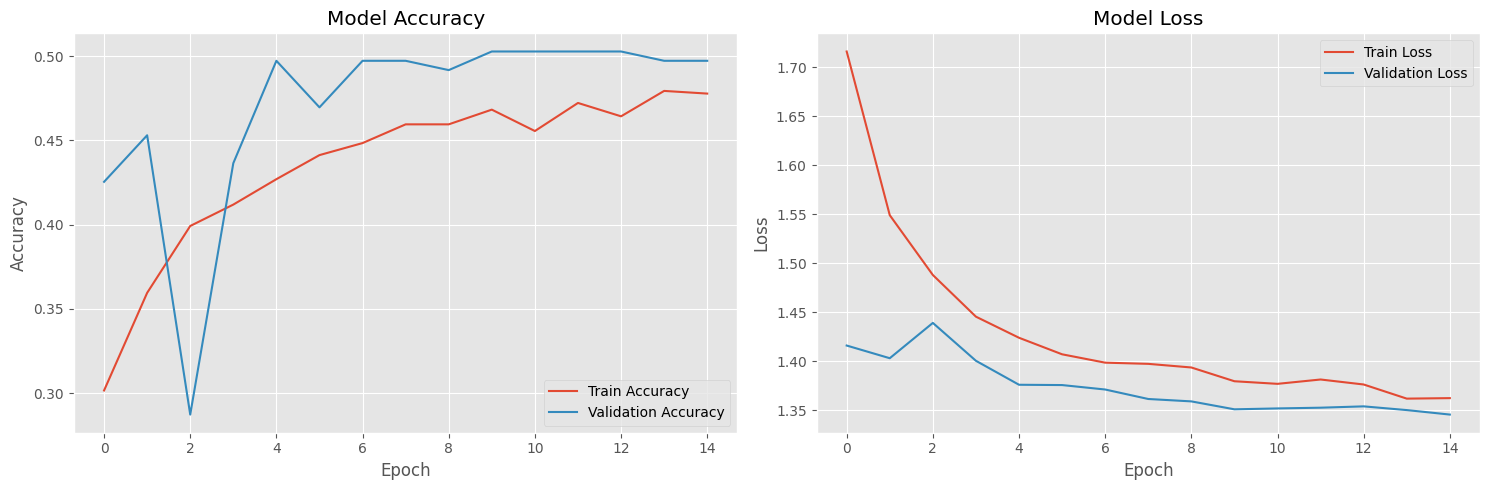


Evaluating model on the test set...
12/12 - 5s - 423ms/step - accuracy: 0.4986 - loss: 1.3376



Test Accuracy: 49.86%
Test Loss: 1.3376

Baseline ResNet50 model saved to 'models/resnet50_baseline.h5'


In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

# --- 1. Load the Preprocessed Data ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')

print("Loading preprocessed data...")
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))

X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))

X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))

with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)

print("Data loaded successfully.")
print(f"  Training data shape: {X_train.shape}")
print(f"  Number of classes: {len(class_names)}")


# --- 2. Define the Model (ResNet50) ---
IMG_SHAPE = (224, 224, 3)
NUM_CLASSES = len(class_names)

# Load ResNet50 pre-trained on ImageNet, without its final classification layer
base_model = ResNet50(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

# Freeze the base model layers
base_model.trainable = False

# Create the final model by adding a custom classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', # Use sparse version as labels are integers
    metrics=['accuracy']
)

model.summary()


# --- 3. Train the Model ---
EPOCHS = 15 # You can adjust this value
BATCH_SIZE = 32 # You can adjust this value

print("\nStarting model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val)
)
print("Model training complete.")


# --- 4. Visualize Performance ---
# Plot training & validation accuracy values
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower right')

# Plot training & validation loss values
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


# --- 5. Evaluate on the Test Set ---
print("\nEvaluating model on the test set...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# --- 6. Save the Trained Model ---
# Create a directory to save models if it doesn't exist
os.makedirs('models', exist_ok=True)
model.save('models/resnet50_baseline.h5')
print("\nBaseline ResNet50 model saved to 'models/resnet50_baseline.h5'")

--- In-Depth Model Evaluation ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 544ms/step

Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        40
        Healty Brinjal       0.43      0.51      0.47       103
      Phomopsis Bright       0.00      0.00      0.00        32
 Shoot and Fruit Borer       0.54      0.88      0.66       145
               Wet Rot       0.00      0.00      0.00        41

              accuracy                           0.50       361
             macro avg       0.19      0.28      0.23       361
          weighted avg       0.34      0.50      0.40       361


Confusion Matrix:



c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Resear

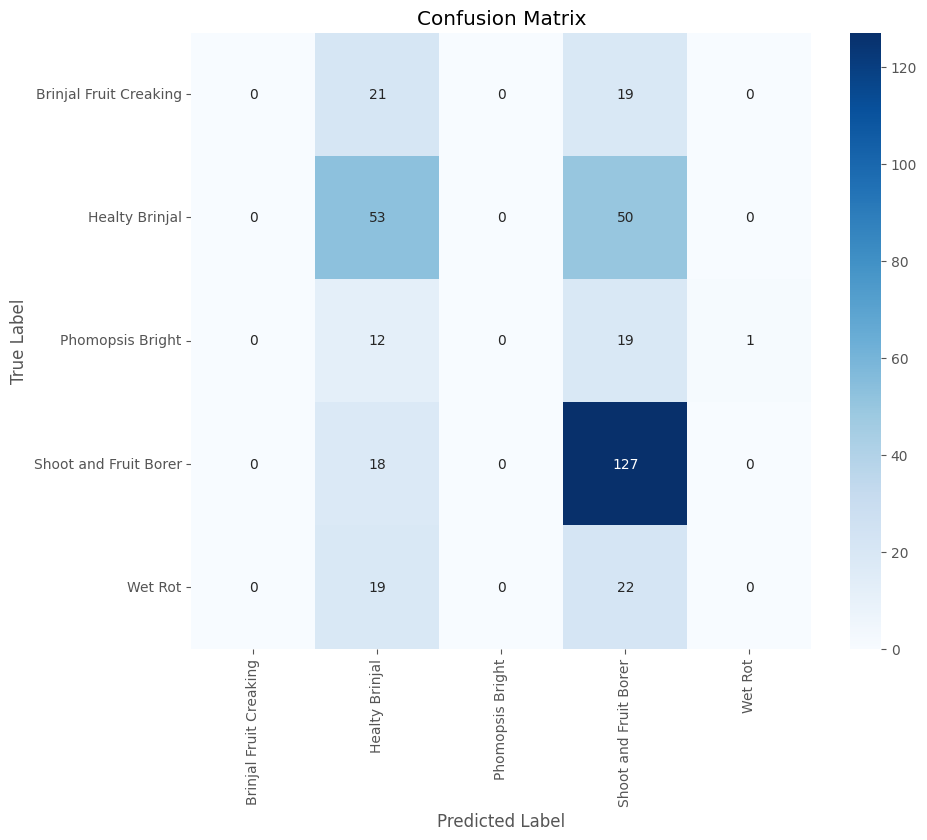

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 5. In-Depth Evaluation (New Section) ---
# This section provides a more detailed breakdown of the model's performance.

print("--- In-Depth Model Evaluation ---")

# 1. Get Predictions
# The model outputs probabilities for each class. We need to find the class with the highest probability.
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 2. Generate Classification Report
# This report provides precision, recall, and f1-score for each class.
print("\nClassification Report:\n")
report = classification_report(y_test, y_pred_classes, target_names=class_names)
print(report)

# 3. Generate and Plot Confusion Matrix
# This shows where the model is getting confused (e.g., misclassifying 'Wet Rot' as 'Healthy').
print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()